In [2]:
%load_ext autoreload
%autoreload 2

In [95]:
import gdown
import pandas as pd
import os

#forcasting
from forecasting.utils.data import TimeSeriesProcessor
from forecasting.forcasting import ARIMAModelHandler, LSTMModelHandler, TFTModelHandler
from forecasting.utils.utils import *

#generation
from genrisk.generation.tcn_gan import TCNGAN
from genrisk.utils.evaluation import *

#worst-risk case
from genrisk.shift import *
from genrisk.utils.utils import *

## Load dataset

In [96]:
def load_gas_supply():
    if not os.path.exists("gas_supply.csv"):
        gdown.download(
            "https://drive.google.com/uc?id=1kGp65UabcFcKAHSM4K2MgkPAYgbyhQj5",
            "gas_supply.csv",
        )
    target = pd.read_csv(
        "gas_supply.csv",
        skiprows=5,
        header=None,
        date_parser=pd.to_datetime,
        index_col=0,
    )
    target = target.sort_index().asfreq("W-Fri")
    target = target.rename(columns={1: "supply"})
    target.index.name = "date"
    target = target.iloc[:1500]
    return target

In [97]:
df_gas = load_gas_supply()

## Data preparation

add exogenous variable

In [6]:
df = TimeSeriesProcessor(df_gas, 0.1, 'D', ['weekofyear'])

obtaining darts data format

In [7]:
train_ts, train_cov, test_ts, test_cov, forecast_horizon, scaler = df.prepare_data(24)

## Forcasting model

training model

In [54]:
arima = ARIMAModelHandler()
arima.train_model(train_ts, train_cov)

get prediction

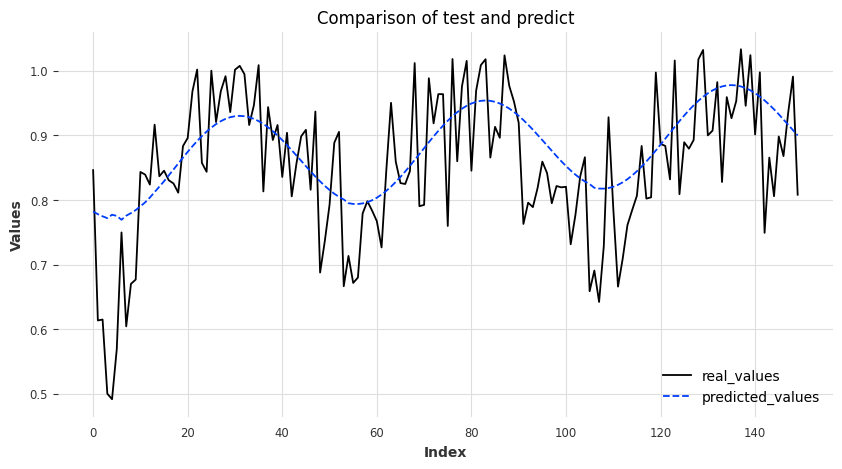

In [59]:
ans = arima.predict(test_cov, len(test_ts))

test_ts_values = list(test_ts.values()) 
ans_values = list(ans.values())  

plot_predictions(ans_values, test_ts_values) 

----

In [57]:
lstm = LSTMModelHandler()
lstm.train_model(train_ts, train_cov)

get prediction on the backtest

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


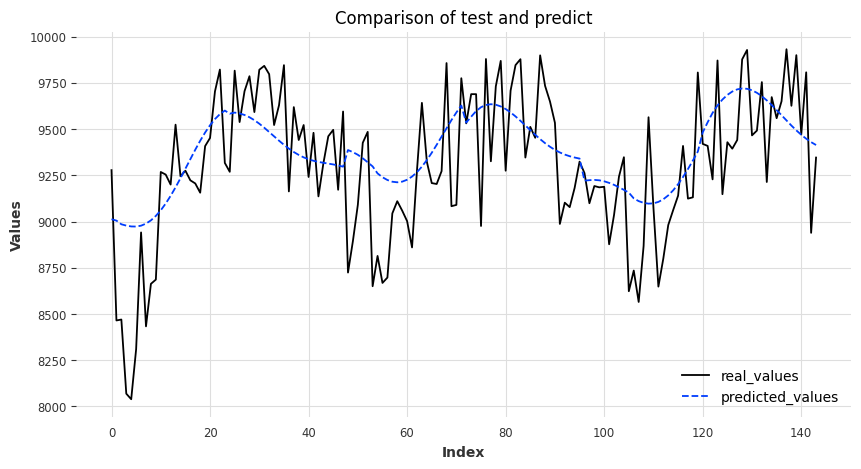

In [58]:
future_pred, future_target = lstm.backtest(
    train_ts, train_cov, test_ts, test_cov, forecast_horizon, scaler
)

plot_predictions(list(future_pred), list(future_target)) 

get prediction

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


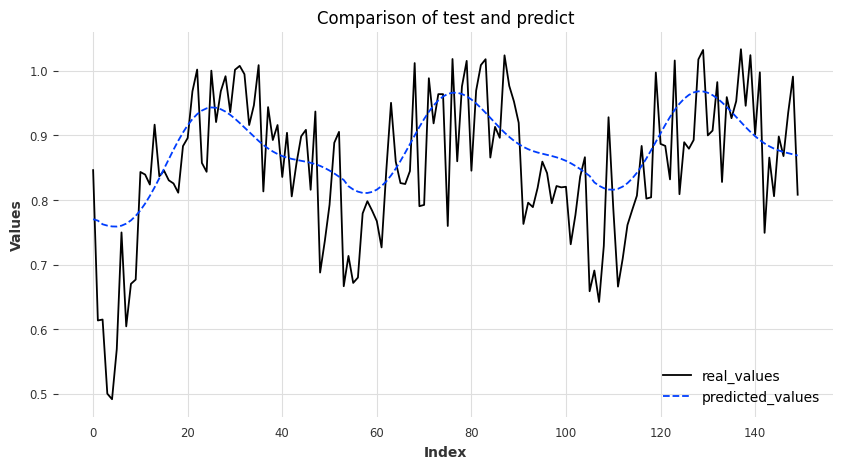

In [41]:
ans = lstm.predict(train_ts, train_cov, test_cov, len(test_ts))

test_ts_values = list(test_ts.values()) 
ans_values = list(ans.values())  

plot_predictions(ans_values, test_ts_values) 

---

In [44]:
tft = TFTModelHandler()
tft.train_model(train_ts, train_cov)

get prediction on the backtest

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


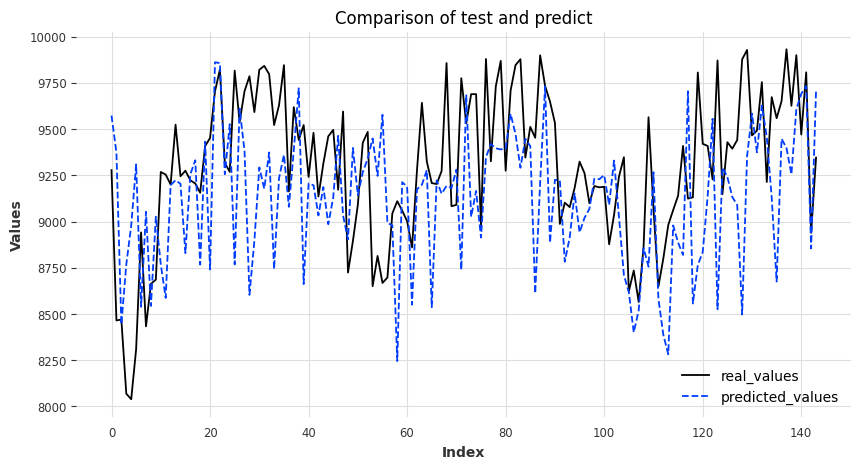

In [47]:
tft.load_model()

future_pred, future_target = tft.backtest(
    train_ts, train_cov, test_ts, test_cov, forecast_horizon, scaler
)

plot_predictions(list(future_pred), list(future_target)) 

get prediction

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


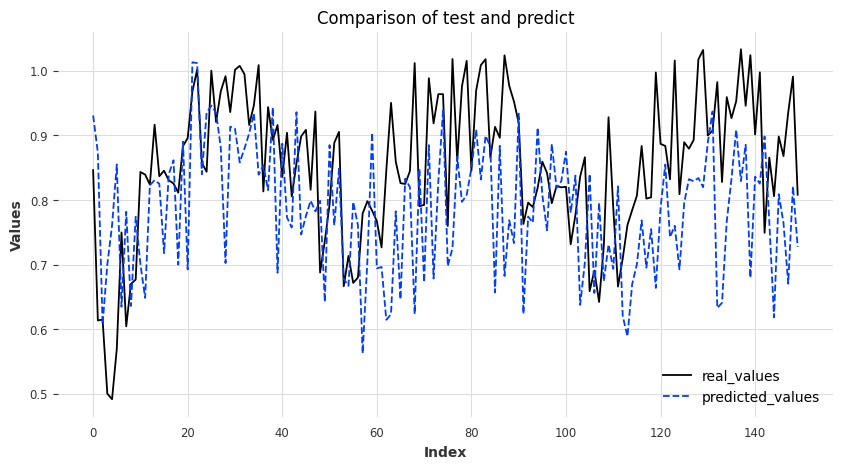

In [48]:
ans = tft.predict(train_ts, train_cov, test_cov, len(test_ts))

test_ts_values = list(test_ts.values()) 
ans_values = list(ans.values())  

plot_predictions(ans_values, test_ts_values) 

## Generation

prepare data to needed format

In [64]:
test_df = test_ts.pd_dataframe()
test_cov_df = test_cov.pd_dataframe()

In [65]:
result_df = pd.merge(
        test_df, test_cov_df, left_index=True, right_index=True
    )

create and fit the model

In [72]:
gen = TCNGAN(
            target_columns=test_df.columns,
            conditional_columns=test_cov_df.columns,
            window_size=100,
            num_epochs=80,
            num_layers=1,
            hidden_dim=64,
            latent_dim=2,
            verbose=True,
            lr=0.01,
            loss_type='Wasseerstein',
        )

In [14]:
gen.fit(result_df)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type              | Params
-------------------------------------------
0 | gen  | _TCNGenerator     | 13.6 K
1 | disc | _TCNDiscriminator | 13.3 K
-------------------------------------------
26.9 K    Trainable params
0         Non-trainable params
26.9 K    Total params
0.108     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=80` reached.


example of saving and loading

In [17]:
gen.save_model('D:/genrisk/generation_models/gen.pth')

In [73]:
gen.load_model('D:/genrisk/generation_models/gen.pth')

plot fake data

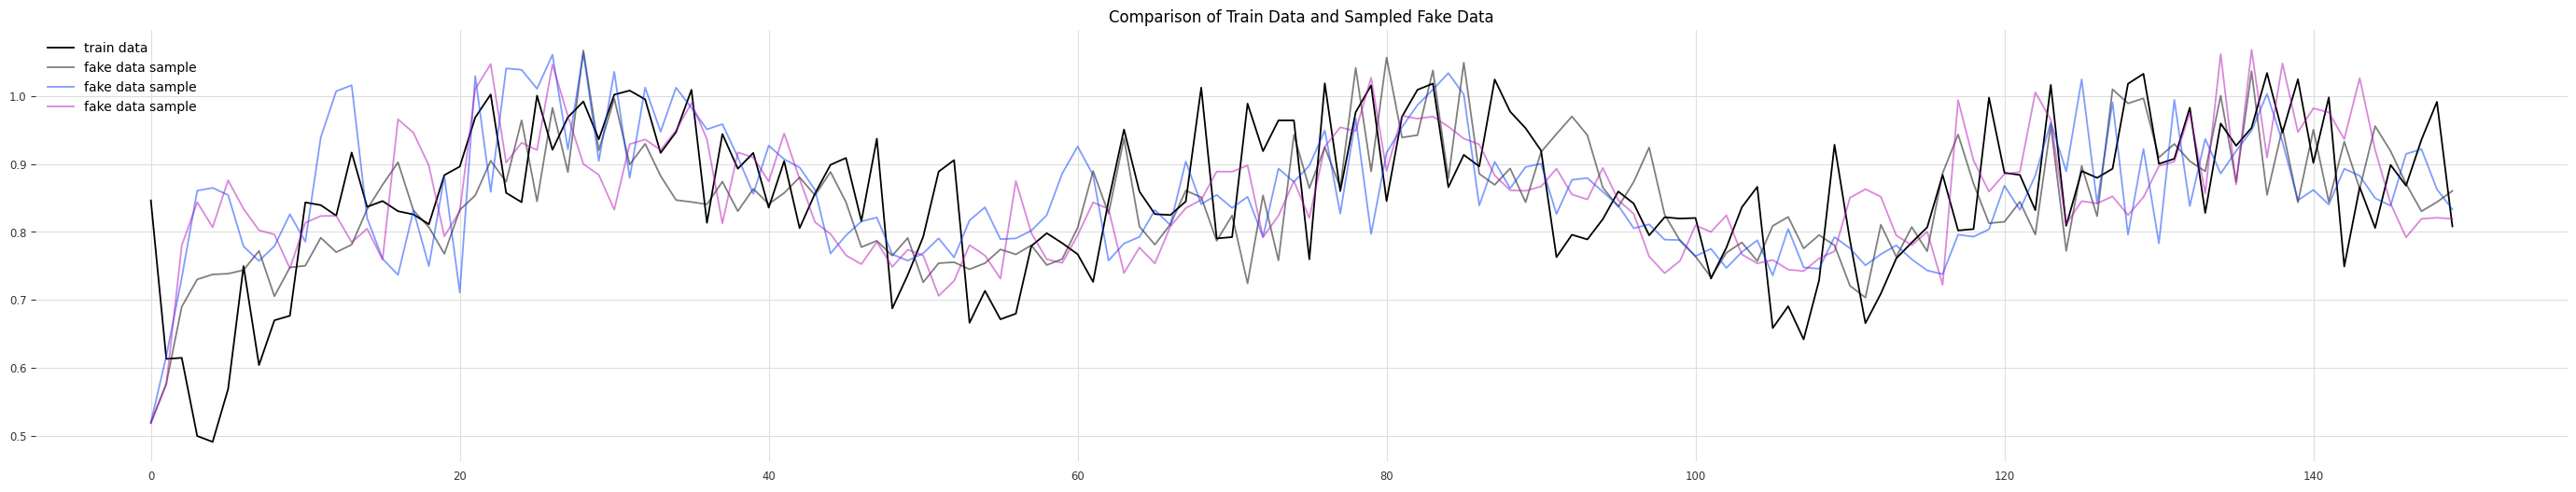

In [93]:
col = 'supply'
n_samples = 3

plot_fake_data(result_df, gen, col=col, n_samples=n_samples)

### Evaluation of generative model

prepare data

In [99]:
fake_data = gen.sample(result_df, n_samples=n_samples)

In [27]:
fake_evl = fake_data[0]['supply']
true_evl = result_df['supply']

different techniques to evaluate

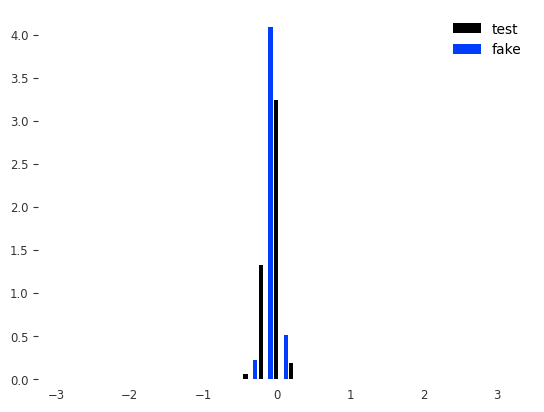

In [30]:
hist2samp(true_evl, fake_evl, 'test', 'fake', nbins=30)

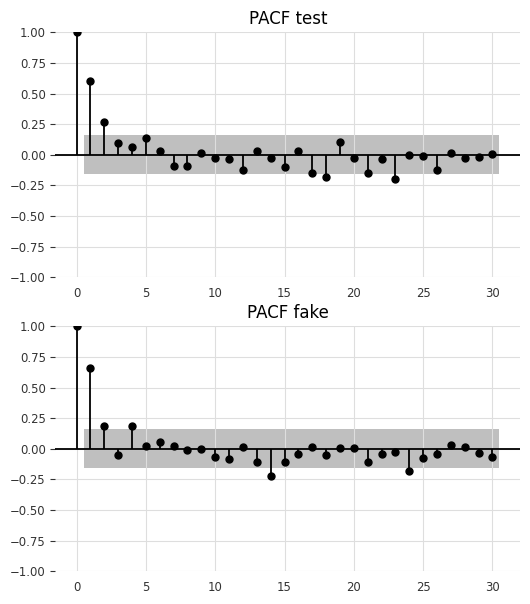

In [31]:
pacf2samp(true_evl, fake_evl, 'test', 'fake', nlags=30)

In [32]:
pacf_error(true_evl, fake_evl)

0.008894271170294524

In [35]:
ks_test(true_evl, fake_evl)

0.4425235033915137

In [40]:
ks_lags_test(true_evl, fake_evl)

0.2873685738507549

## Worsk-case risk

create model for finding shifts

In [66]:
shift_model = ConditionalShift(
    mutable_columns=list(test_df.columns),
    immutable_columns=list(test_cov_df.columns),
    alpha_space=np.linspace(0.05, 0.95, 10),
    cv=5,
    # mode = 'gbr_quantiles'
)

examles to plot only fake or real worsk-case risk data

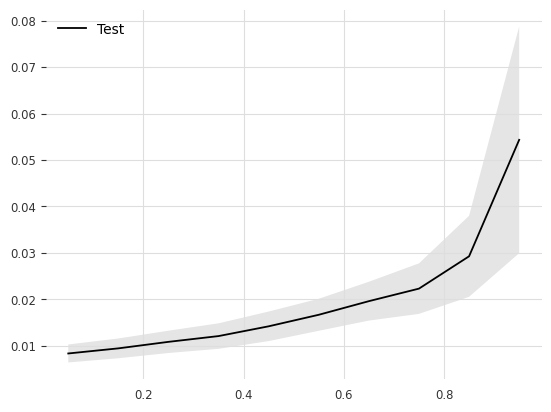

In [98]:
arima = ARIMAModelHandler()
ans = arima.predict(test_cov, len(test_ts))

plot_test_wcr(ans, shift_model, test_ts, result_df)

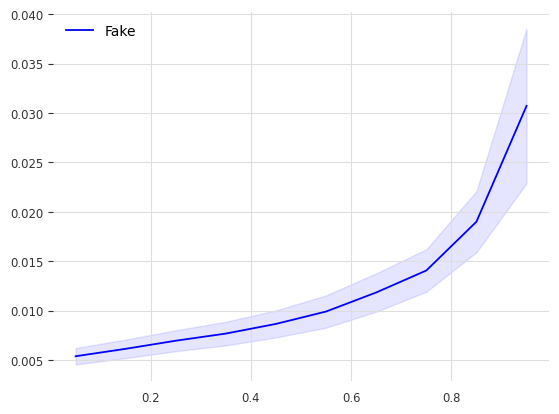

In [89]:
arima = ARIMAModelHandler()
ans = arima.predict(test_cov, len(test_ts))

plot_fake_wcr(ans, shift_model, fake_data, col)

plot comparison of both (fake and real) worst-case risk

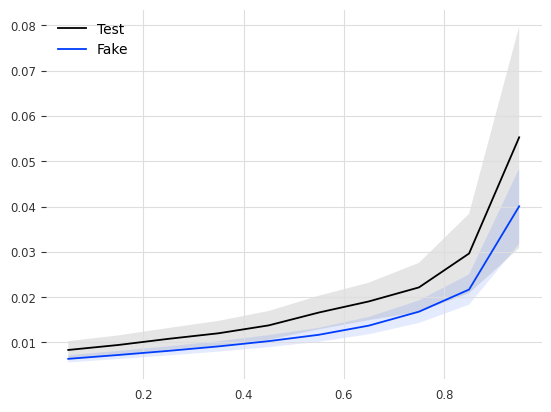

In [100]:
arima = ARIMAModelHandler()
ans = arima.predict(test_cov, len(test_ts))

plot_pair_wcr(ans,
    shift_model,
    test_ts,
    result_df,
    fake_data,
    col)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


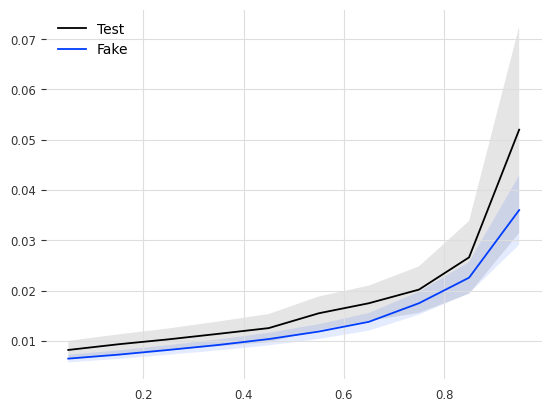

In [80]:
lstm = LSTMModelHandler()
ans = lstm.predict(train_ts, train_cov, test_cov, len(test_ts))
plot_pair_wcr(ans,
    shift_model,
    test_ts,
    result_df,
    fake_data,
    col)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


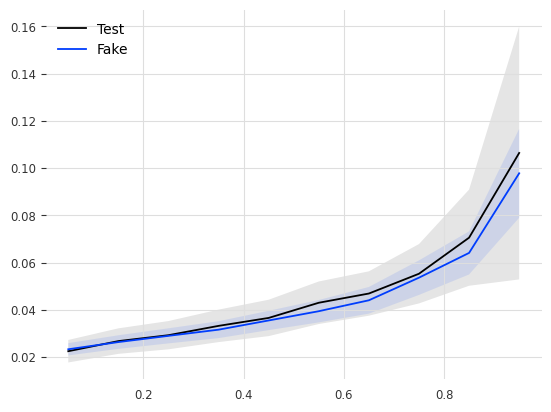

In [81]:
tft = TFTModelHandler()
ans = tft.predict(train_ts, train_cov, test_cov, len(test_ts))
plot_pair_wcr(ans,
    shift_model,
    test_ts,
    result_df,
    fake_data,
    col)